# pyPCG Example code
## version: WIP
### Kristóf Müller (muller.kristof@itk.ppke.hu)

Import modules:

In [1]:
import pyPCG as pcg
import pyPCG.io as signal_io
import pyPCG.preprocessing as preproc
import pyPCG.segment as sgm
import pyPCG.features as ftr
import pyPCG.stats as sts

Read in data:

In [2]:
data, fs = signal_io.read_signal_file("example.wav","wav")
example = pcg.pcg_signal(data,fs)

Plot data:

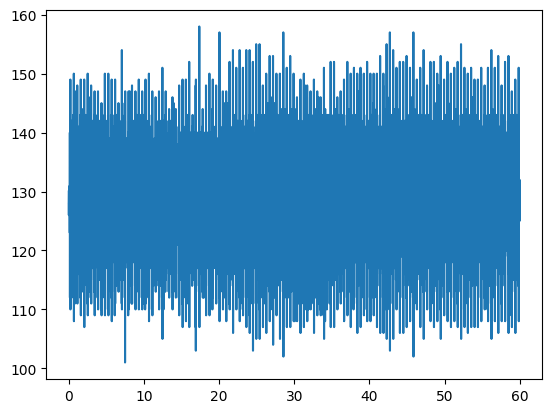

In [3]:
pcg.plot(example)

Normalization:

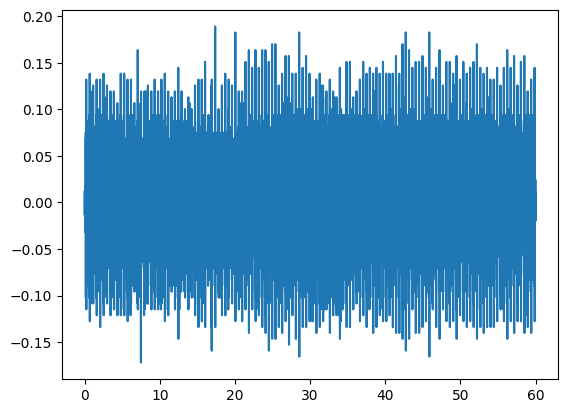

In [4]:
norm_signal = pcg.normalize(example)
pcg.plot(norm_signal)

Create processing pipeline:

In [5]:
from functools import partial
lp_filter = partial(preproc.filter, filt_ord=6, filt_cutfreq=100, filt_type="LP")
hp_filter = partial(preproc.filter, filt_ord=6, filt_cutfreq=20, filt_type="HP")

my_pipeline = pcg.process_pipeline(lp_filter,hp_filter,preproc.wt_denoise,preproc.homomorphic)

['Unit scale', 'Zero center', 'LP Filter (order-6, cut-100)', 'HP Filter (order-6, cut-20)', 'Wavelet denoise (family-coif4, level-5, th-0.2)', 'Homomorphic envelope (order-6,cut-8)']


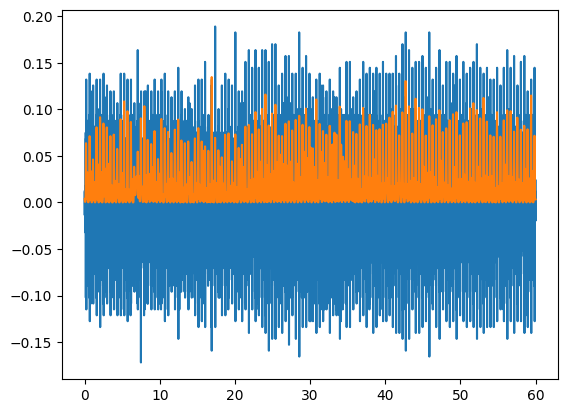

In [6]:
processed = my_pipeline.run(norm_signal)
print(processed.processing_log)
pcg.plot(norm_signal)
pcg.plot(processed)

Segment S1 sounds with peak detection

In [7]:
peakvals, peaks = sgm.adv_peak(processed)
s1,s2 = sgm.peak_sort_diff(peaks)
st,en = sgm.segment_peaks(s1,processed)

Calculate features:

In [8]:
a = ftr.time_delta(st,en,processed)
b = ftr.ramp_time(st,en,processed)
c = ftr.ramp_time(st,en,processed,type="exit")
d = ftr.zero_cross_rate(st,en,norm_signal)
e = ftr.peak_width(st,en,processed,factor=0.8)
f,g = ftr.peak_centroid(st,en,processed)
h,i = ftr.max_freq(st,en,norm_signal,nfft=1024)
j = ftr.spectral_width(st,en,norm_signal,nfft=1024)
k,l = ftr.spectral_centroid(st,en,norm_signal,nfft=1024)
m = ftr.spectrum_raw(st,en,processed,nfft=1024)

Statistics of features:

In [9]:
print(sts.mean(a))
print(sts.std(b))
print(sts.med(d))
feat_spectral_kurt = sts.kurt(m)
win_time, win_val = sts.window_operator(a,10,sts.mean)

0.06398880083090609
0.004956791053086932
0.18421052631578946


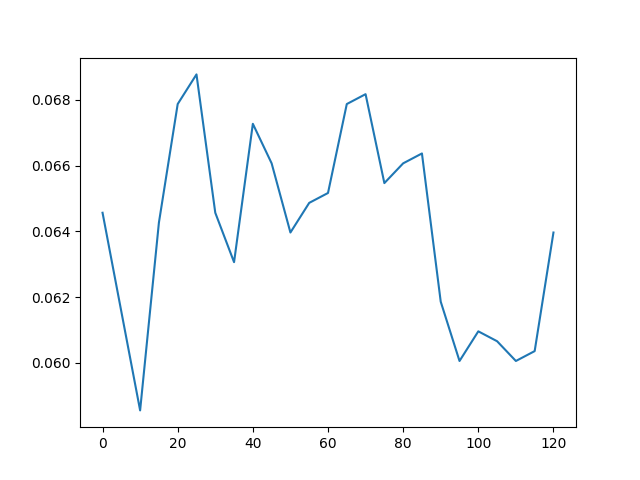

In [10]:
import matplotlib.pyplot as plt
%matplotlib widget

plt.figure()
plt.plot(win_time,win_val)

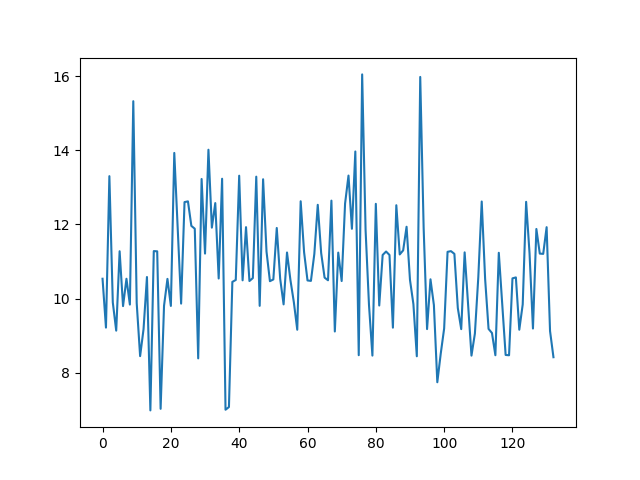

In [11]:
plt.figure()
plt.plot(feat_spectral_kurt)

Use the previous data to calculate RMSSD:

In [12]:
import numpy as np

# S1 start times offset from each other and converted to msec
st_1 = np.round((st[:-1]/processed.fs)*1000).astype(int)
st_2 = np.round((st[1:]/processed.fs)*1000).astype(int)

# Time differences
diff = ftr.time_delta(st_1,st_2,processed)

# RMS of differences -> RMSSD
print(sts.rms(diff))

1.3514636306880639
